In [1]:
!pip install protobuf==4.23.4 --force-reinstall --no-deps -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 9.1 MB/s eta 0:00:00


In [2]:
!pip install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.5 MB/s eta 0:00:00a 0:00:01


In [3]:
!pip install audiomentations==0.33.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.11.0
    Uninstalling librosa-0.11.0:
      Successfully uninstalled librosa-0.11.0


**Load important libraries**

In [4]:
import os
import random
import torch
import torchaudio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from transformers import AutoFeatureExtractor, ASTForAudioClassification
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Gain

2025-12-22 14:10:48.979562: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766412649.161264      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766412649.212001      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Set seed for Reproducibility

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
# Load FMA metadata

tracks = pd.read_csv(
    "/kaggle/input/fma-free-music-archive-small-medium/fma_metadata/tracks.csv",
    index_col=0,
    header=[0, 1]
)

genres = tracks[('track', 'genre_top')]
subset = tracks[('set', 'subset')]

small_ids = tracks[subset == "small"].index
genres = genres.loc[small_ids].dropna()

genre_list = sorted(genres.unique())
label2id = {g: i for i, g in enumerate(genre_list)}
id2label = {i: g for g, i in label2id.items()}
genres_encoded = genres.map(label2id)

train_ids, test_ids = train_test_split(
    genres.index, test_size=0.1, stratify=genres_encoded, random_state=SEED
)

train_ids, val_ids = train_test_split(
    train_ids, test_size=0.1, stratify=genres_encoded.loc[train_ids], random_state=SEED
)

print(f"Train: {len(train_ids)}  Val: {len(val_ids)}  Test: {len(test_ids)}")

AUDIO_ROOT = "/kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small"

Train: 6480  Val: 720  Test: 800



**FMA-Small Dataset with audio augmentation (applied only in training mode)**

**Supports raw-audio AST input with resampling, fixed-length padding, and robust preprocessing**



In [7]:
class FMASmallDataset(Dataset):
    def __init__(self, ids, labels, feature_extractor, audio_root=AUDIO_ROOT, max_len_seconds=30, train_mode=False):
        self.ids = list(ids)
        self.labels = labels
        self.feature_extractor = feature_extractor
        self.audio_root = audio_root
        self.train_mode = train_mode
        self.max_length = int(16000 * max_len_seconds)

        if train_mode:
            self.augment = Compose([
                AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
                TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
                PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
                Shift(min_shift=-0.5, max_shift=0.5, p=0.5),   
                Gain(min_gain_in_db=-6, max_gain_in_db=6, p=0.5),
            ])
        else:
            self.augment = None

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        track_id = int(self.ids[idx])
        label = int(self.labels[track_id])

        folder = f"{track_id // 1000:03d}"
        filename = f"{track_id:06d}.mp3"
        path = os.path.join(self.audio_root, folder, filename)

        try:
            waveform, sr = torchaudio.load(path)
        except Exception:
            waveform = torch.zeros(1, self.max_length)
            sr = 16000

        # Mono
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        waveform = waveform.squeeze()

        # Resample
        if sr != 16000:
            waveform = torchaudio.functional.resample(waveform, sr, 16000)

        # Trim or pad
        if waveform.numel() > self.max_length:
            waveform = waveform[:self.max_length]
        else:
            waveform = torch.nn.functional.pad(waveform, (0, self.max_length - waveform.numel()))

        # Convert to numpy for audiomentations
        waveform_np = waveform.numpy()

        # Apply augmentation only during training
        if self.train_mode:
            waveform_np = self.augment(samples=waveform_np, sample_rate=16000)

        waveform = torch.tensor(waveform_np)

        inputs = self.feature_extractor(waveform, sampling_rate=16000, return_tensors="pt")
        return inputs["input_values"][0], torch.tensor(label, dtype=torch.long)

In [8]:
# Feature extractor + datasets

feature_extractor = AutoFeatureExtractor.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593"
)

train_ds = FMASmallDataset(train_ids, genres_encoded, feature_extractor, train_mode=True)
val_ds = FMASmallDataset(val_ids, genres_encoded, feature_extractor)
test_ds = FMASmallDataset(test_ids, genres_encoded, feature_extractor)

preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

**Weighted sampler to address class imbalance by oversampling underrepresented genres during training**

In [9]:
# Weighted sampler

class_weights = 1. / genres_encoded.value_counts()
sample_weights = genres_encoded.loc[train_ids].map(class_weights).values

sampler = WeightedRandomSampler(
    weights=torch.DoubleTensor(sample_weights),
    num_samples=len(train_ids),
    replacement=True
)

In [10]:
# DataLoader

train_loader = DataLoader(
    train_ds, batch_size=8, sampler=sampler,
    num_workers=2, pin_memory=True
)

val_loader = DataLoader(
    val_ds, batch_size=8, shuffle=False,
    num_workers=2, pin_memory=True
)

test_loader = DataLoader(
    test_ds, batch_size=8, shuffle=False,
    num_workers=2, pin_memory=True
)

print("Datasets ready.")

Datasets ready.


**Load pretrained AST model, freeze backbone for initial fine-tuning, and train only the classification head**

In [11]:
# Model (Freeze first, then unfreeze later)

model = ASTForAudioClassification.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593",
    num_labels=len(genre_list),
    ignore_mismatched_sizes=True,
    label2id=label2id,
    id2label=id2label
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Freeze all transformer layers first
for param in model.base_model.parameters():
    param.requires_grad = False

print("Initial training: AST layers frozen.")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initial training: AST layers frozen.



**Functions for training and evaluating the model per epoch**

**train_epoch: updates model parameters, tracks loss and accuracy**

**eval_epoch: computes validation loss, accuracy, and stores predictions**



In [12]:
# Training and evalation helper function

def train_epoch(model, loader):
    model.train()
    total_loss = 0
    preds_all, labels_all = [], []

    bar = tqdm(loader, leave=False)
    for x, y in bar:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        logits = model(x).logits
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        # Track predictions for accuracy
        preds = logits.argmax(dim=1)
        preds_all.extend(preds.cpu().tolist())
        labels_all.extend(y.cpu().tolist())

        total_loss += loss.item() * x.size(0)
        bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = total_loss / len(loader.dataset)
    acc = (np.array(preds_all) == np.array(labels_all)).mean()

    return avg_loss, acc

def eval_epoch(model, loader):
    model.eval()
    total_loss = 0
    preds_all, labels_all = [], []

    with torch.no_grad():
        bar = tqdm(loader, leave=False)
        for x, y in bar:
            x, y = x.to(DEVICE), y.to(DEVICE)

            logits = model(x).logits
            loss = criterion(logits, y)

            preds = logits.argmax(dim=1)

            preds_all.extend(preds.cpu().tolist())
            labels_all.extend(y.cpu().tolist())

            total_loss += loss.item() * x.size(0)
            bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = total_loss / len(loader.dataset)
    acc = (np.array(preds_all) == np.array(labels_all)).mean()

    return avg_loss, acc, preds_all, labels_all


**Two-Stage Training with Early Stopping and LR SchedulerStage**

**1: Train only the classifier head while keeping AST transformer layers frozenStage**

**2: Unfreeze last two transformer layers for fine-tuning**

**Tracks training/validation loss and accuracy, applies ReduceLROnPlateau scheduler**

**Implements early stopping to save the best model based on validation loss**



In [13]:
# Two-stage training + early stopping + scheduler

train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

EPOCHS_STAGE1 = 5
EPOCHS_STAGE2 = 3

best_val_loss = float("inf")
patience = 2
patience_counter = 0

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=1, factor=0.5
)

# Stage 1: Train only the classifier head 

print("\n STAGE 1: Training classifier head")

for epoch in range(EPOCHS_STAGE1):
    print(f"\nEpoch {epoch+1}/{EPOCHS_STAGE1}")

    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_acc, _, _ = eval_epoch(model, val_loader)
    # store curves
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_accuracies.append(train_acc)

    print(f"Train Loss: {train_loss:.4f} |  Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f}  |  Val Acc: {val_acc:.4f}")

    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered (Stage 1).")
            break

# Stage 2: Unfreeze last two transformer layers

print("\nUnfreezing last 2 transformer layers...")

for name, param in model.base_model.named_parameters():
    if "encoder.layer.10" in name or "encoder.layer.11" in name:
        param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

print("STAGE 2: Fine-tuning last layers ")

for epoch in range(EPOCHS_STAGE2):
    print(f"\nEpoch {epoch+1}/{EPOCHS_STAGE2}")

    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_acc, _, _ = eval_epoch(model, val_loader)
    # store curves
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_accuracies.append(train_acc)

    print(f"Train Loss: {train_loss:.4f} |  Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f}  |  Val Acc: {val_acc:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")


 STAGE 1: Training classifier head

Epoch 1/5


Train Loss: 1.4566 |  Train Acc: 0.5051
Val Loss:   1.2807  |  Val Acc: 0.5806

Epoch 2/5


Train Loss: 1.1901 |  Train Acc: 0.6006
Val Loss:   1.2133  |  Val Acc: 0.5931

Epoch 3/5


Train Loss: 1.1503 |  Train Acc: 0.6077
Val Loss:   1.1899  |  Val Acc: 0.6056

Epoch 4/5


Train Loss: 1.1371 |  Train Acc: 0.6048
Val Loss:   1.1697  |  Val Acc: 0.6000

Epoch 5/5


Train Loss: 1.1083 |  Train Acc: 0.6153
Val Loss:   1.1510  |  Val Acc: 0.6111

Unfreezing last 2 transformer layers...
STAGE 2: Fine-tuning last layers 

Epoch 1/3


Train Loss: 1.0742 |  Train Acc: 0.6336
Val Loss:   1.1130  |  Val Acc: 0.6153

Epoch 2/3


Train Loss: 1.0170 |  Train Acc: 0.6478
Val Loss:   1.0919  |  Val Acc: 0.6347

Epoch 3/3


Train Loss: 0.9669 |  Train Acc: 0.6681
Val Loss:   1.0530  |  Val Acc: 0.6194



Evaluating on TEST set...



Classification Report:
               precision    recall  f1-score   support

   Electronic       0.66      0.77      0.71       100
 Experimental       0.66      0.43      0.52       100
         Folk       0.62      0.68      0.65       100
      Hip-Hop       0.70      0.80      0.74       100
 Instrumental       0.59      0.76      0.67       100
International       0.76      0.72      0.74       100
          Pop       0.45      0.33      0.38       100
         Rock       0.62      0.60      0.61       100

     accuracy                           0.64       800
    macro avg       0.63      0.64      0.63       800
 weighted avg       0.63      0.64      0.63       800



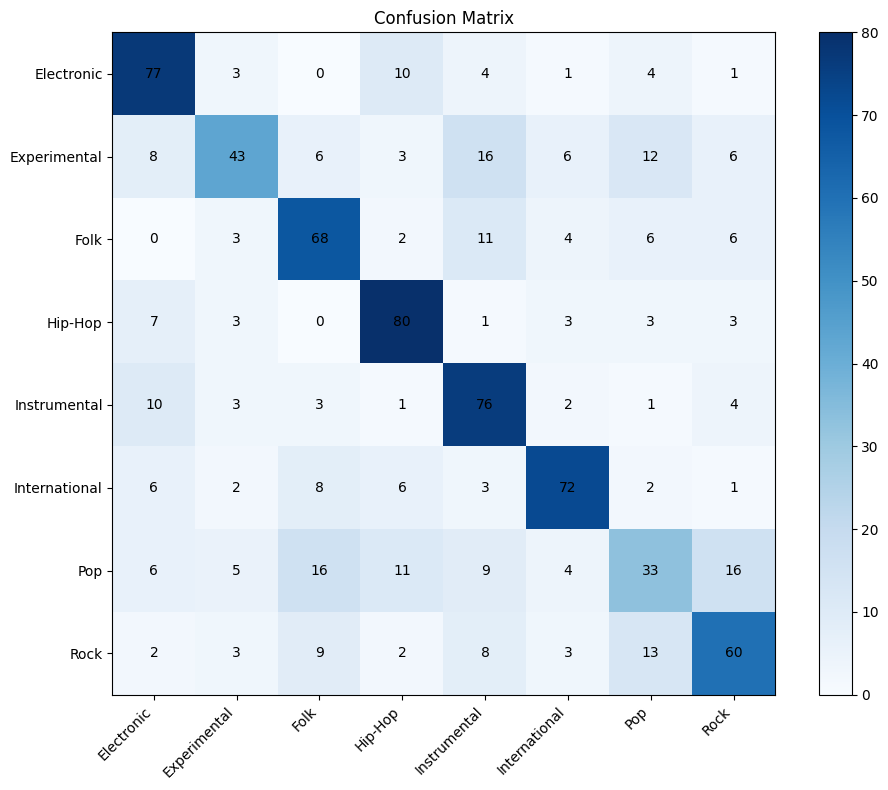

In [14]:
# Load best model + Test evaluation

model.load_state_dict(torch.load("best_model.pt"))

print("\nEvaluating on TEST set...")
_, _, preds, labels_true = eval_epoch(model, test_loader)

print("\nClassification Report:")
print(classification_report(labels_true, preds, target_names=genre_list))

cm = confusion_matrix(labels_true, preds)

plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

plt.xticks(range(len(genre_list)), genre_list, rotation=45, ha="right")
plt.yticks(range(len(genre_list)), genre_list)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

In [15]:
model.load_state_dict(torch.load("best_model.pt"))
torch.save(model, "/kaggle/working/ast_genre_classifier_full.pth")

import pickle
with open("label_mappings.pkl", "wb") as f:
    pickle.dump({"label2id": label2id, "id2label": id2label}, f)

print("Model + labels saved")

Model + labels saved


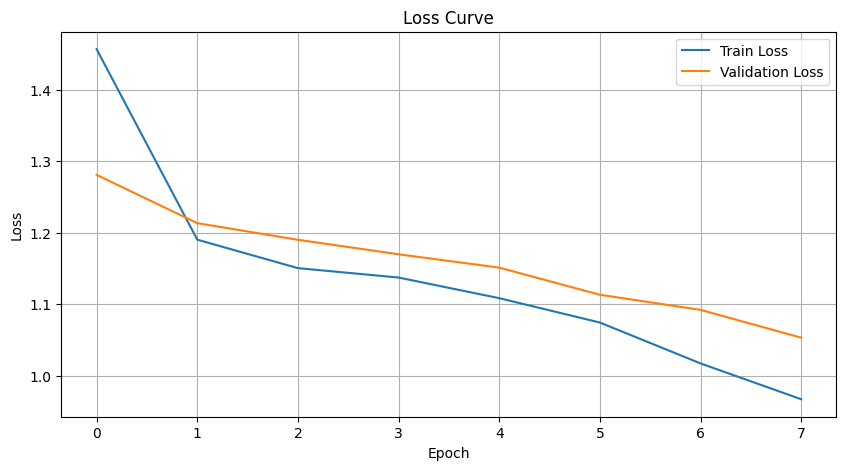

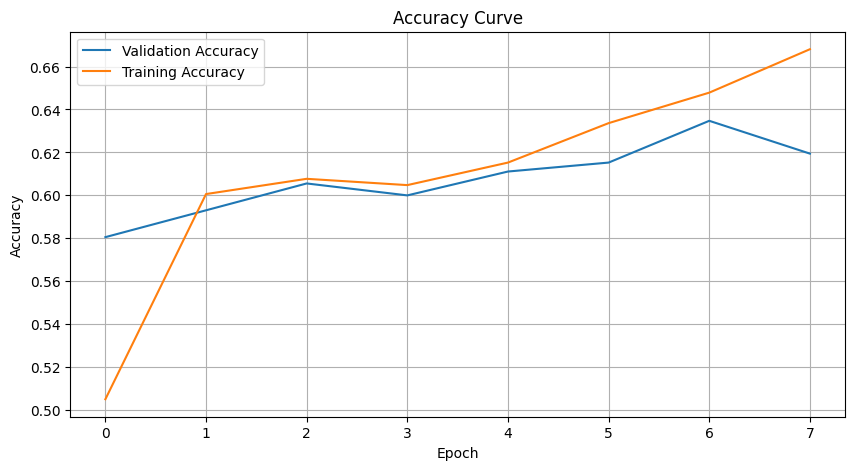

In [16]:
# Loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label="Validation Accuracy")
plt.plot(train_accuracies, label="Training Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

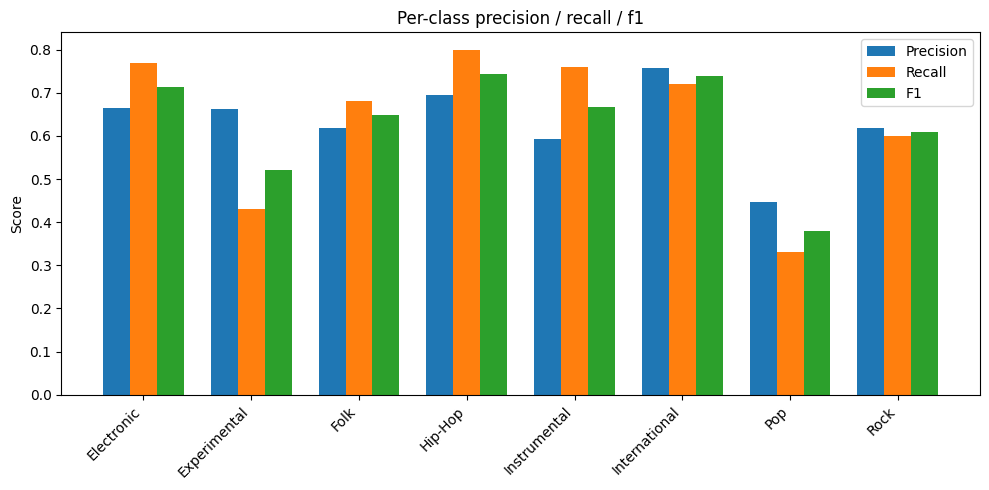

In [17]:
# Per-class precision / recall / F1 bar chart
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_fscore_support

prec, rec, f1, support = precision_recall_fscore_support(labels_true, preds, zero_division=0)
x = np.arange(len(genre_list))

plt.figure(figsize=(10,5))
plt.bar(x-0.25, prec, width=0.25, label="Precision")
plt.bar(x, rec, width=0.25, label="Recall")
plt.bar(x+0.25, f1, width=0.25, label="F1")
plt.xticks(x, genre_list, rotation=45, ha="right")
plt.ylabel("Score")
plt.title("Per-class precision / recall / f1")
plt.legend()
plt.tight_layout()
plt.show()